# Part 2: Initial Error Analysis


In this notebook, we will cover:

- Generating traces from our `user_queries`
- How we do open coding in Braintrust
- How we can use Braintrust for axial coding and defining our failure mode taxonomy
- Visualize our failure modes and upload results to Braintrust

Let's start by importing the required libraries.


In [2]:
import json
import os
import sys

from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(os.path.abspath(".."))
import braintrust as bt
import openai as oai
import requests

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from backend.utils import get_agent_response

load_dotenv(override=True)

/Users/wgilliam/development/demos/ai_evals_course_202507/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Setup


In [3]:
BT_PROJECT_NAME = "recipe-bot"
bt_project = bt.projects.create(name=BT_PROJECT_NAME)

oai_client = oai.OpenAI(base_url="https://api.braintrust.dev/v1/proxy", api_key=os.getenv("OPENAI_API_KEY"))


## Step 1: Run Bot on Synthetic Queries


In [3]:
all_queries_ds = bt.init_dataset(project=BT_PROJECT_NAME, name="user_queries")
rows = list(all_queries_ds)

print(len(rows))
rows[0]

135


{'_pagination_key': 'p07532347662115799127',
 '_xact_id': '1000195526757082408',
 'created': '2025-07-29T03:55:53.713Z',
 'dataset_id': '15b4cc00-8f27-400b-a312-31cb036fe7e4',
 'expected': None,
 'id': '44de1888-c29f-4288-b213-d6486ed0727e',
 'input': 'can u help me find a quick recipe with salmon and avocado from trader joes? need some nutritional guidance for this dish',
 'is_root': True,
 'metadata': {'id': '20250728_2025_001',
  'model': 'gpt-4o-mini',
  'model_kwargs': {},
  'source': 'synth'},
 'origin': None,
 'project_id': '54782088-3418-41ea-acda-d6302c2dfa64',
 'root_span_id': 'f55838b6-87ac-4d16-ba73-6835b97753e3',
 'span_id': 'f55838b6-87ac-4d16-ba73-6835b97753e3',
 'tags': None}

In [5]:
# get_agent_response(
#     messages=[{"role": "user", "content": rows[0]["input"]}],  # type: ignore
#     metadata=rows[0]["metadata"],  # type: ignore
# )

In [6]:
for row in rows:
    rsp = get_agent_response(
        messages=[{"role": "user", "content": row["input"]}],  # type: ignore
        metadata=row["metadata"],  # type: ignore
    )
    # print(rsp)

## Step 2: Open Coding


We will do the reviewing of interaction traces, assigning descriptive labels/notes to identify patterns and potential errors without preconceived categories in the Braintrust UI with [human review](https://www.braintrust.dev/docs/guides/human-review).


## Step 3: Axial Coding & Taxonomy Definition


### Define our failure modes


In [12]:
def get_annotated_traces(return_only_human_reviews: bool = False):
    if return_only_human_reviews:
        filter_str = "filter: metadata.human_review is not null and metadata.human_review != ''"
    else:
        filter_str = "filter: metadata.source is not null"

    cursor = None
    while True:
        response = requests.post(
            "https://api.braintrust.dev/btql",
            json={
                "query": f"""
                    select: *
                    from: project_logs('54782088-3418-41ea-acda-d6302c2dfa64')
                    {filter_str}
                    limit: 1000"""
                + (f" | cursor: '{cursor}'" if cursor else ""),
                "use_brainstore": True,
                "brainstore_realtime": True,  # Include the latest realtime data, but a bit slower.
            },
            headers={
                # Substitute your API key here
                "Authorization": "Bearer " + os.environ["BRAINTRUST_API_KEY"],
            },
        )
        response.raise_for_status()
        response_json = response.json()
        data = response_json.get("data", [])
        cursor = response_json.get("cursor")

        return data

In [13]:
annotated_traces = get_annotated_traces(True)

print(len(annotated_traces))
print(annotated_traces[0])

21
{'_pagination_key': 'p07532367387736997888', '_xact_id': '1000195527113454159', 'context': {'caller_filename': '/var/folders/y4/d83v3kjj0hj4m3jpqfdkbng40000gn/T/ipykernel_22345/3306963652.py', 'caller_functionname': '<module>', 'caller_lineno': 2}, 'created': '2025-07-29T05:12:26.374Z', 'error': None, 'expected': None, 'id': 'e26719da-2ae7-4f8f-962d-0426f84fea91', 'input': [{'content': '# Role and Objective\nYou are a friendly, health-conscious culinary assistant. Your primary goal is to provide **easy-to-follow, high-protein, macro-friendly, and meal-prep-friendly recipes**. **You should ALWAYS attempt to provide a recipe recommendation, even if the user\'s request is vague, health-related, or nutrition-focused.**\nAvoid recommending recipes with harmful chemicals (e.g., red dye #5) or known to contain microplastics.\n\n# Instructions\n\n## Core Recipe Principles\n1.  **Protein-Focused**: Prioritize protein-rich, satisfying meals aiming for at least 25-30g protein per serving. Util

#### Use an LLM to get us started


In [14]:
class TraceExample(BaseModel):
    input_id: str | None = Field(..., description="The id of the input to the example if it exists")
    input: str = Field(..., description="The entire input to the example")
    output_issue: str = Field(..., description="The issue with the output")


class FailureMode(BaseModel):
    title: str = Field(..., description="A short title, 3-5 words, for the failure mode.")
    slug: str = Field(..., description="A slug for the failure mode, 3-5 words, in snake_case.")
    description: str = Field(..., description="A short one sentence description of the failure mode.")
    examples: list[TraceExample] = Field(..., description="A list of examples of the failure mode.", min_length=1, max_length=3)


class FailureModeList(BaseModel):
    failure_modes: list[FailureMode] = Field(..., description="A list of failure modes.")


In [15]:
def get_failure_modes(traces: list[dict]):
    # Extract all human review comments
    if not traces:
        return []

    prompt = f"""\
Analyze the following human feedback provided for each of the examples below to identify the high-level failure modes present 
in the examples.

Examples with Human Reviews, Inputs, and AI Outputs:
"""
    for trace in traces:
        input_id = str(trace.get("metadata", {}).get("id", "N/A"))
        input_text = trace.get("input", [])[-1]["content"]
        output_text = trace.get("output", [])[-1]["content"]
        human_review = trace.get("metadata", {}).get("human_review", "N/A")

        prompt += f"-----\n<input_id>{input_id}</input_id>\n<input>:\n{input_text}\n</input>\n<output>\n{output_text}\n</output>\n<human_review>\n{human_review}\n</human_review>\n-----"

    prompt += """\
\nReturn only the high-level failure modes that appear across these reviews as a list of strings and examples of the inputs and outputs that demonstrate the failure mode."""

    # return prompt

    response = oai_client.chat.completions.parse(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": "You are an expert at analyzing feedback to identify high-level systematic failure patterns."},
            {"role": "user", "content": prompt},
        ],
        response_format=FailureModeList,
        temperature=0.1,
    )

    return response.choices[0].message.parsed  # type: ignore

In [22]:
failure_mode_list = get_failure_modes(annotated_traces)

In [23]:
with open("failure_modes.json", "w") as f:
    json.dump(failure_mode_list.model_dump(), f, indent=2)  # type ignore

print("Failure modes saved to failure_modes.json")


Failure modes saved to failure_modes.json


### Save our taxonomy definitions as markdown for review


In [ ]:
def save_failure_modes_to_markdown(failure_mode_list_d: dict, filename="failure_mode_taxonomy.md"):
    """
    Save failure modes to a markdown file with proper formatting.
    """

    failure_mode_list = FailureModeList(**failure_mode_list_d)
    md_content = []

    # Header
    md_content.append("# Failure Mode Taxonomy")
    md_content.append("")
    md_content.append(
        "This document outlines the failure modes observed or anticipated for the Recipe Chatbot. Each failure mode includes a title, a concise definition, and illustrative examples."
    )
    md_content.append("")

    # Iterate through each failure mode
    for i, fm in enumerate(failure_mode_list.failure_modes, 1):
        # Failure mode header
        md_content.append(f"## Failure Mode {i}: {fm.title}")
        md_content.append("")

        # Basic info with markdown formatting
        md_content.append(f"- **Definition**: {fm.description}")
        md_content.append(f"- **Slug**: `{fm.slug}`")
        md_content.append("")

        # Examples section
        if fm.examples:
            md_content.append("### Examples")
            md_content.append("")

            for j, example in enumerate(fm.examples, 1):
                md_content.append(f'{j}. **User Query**: "(id: {example.input_id or "N/A"}) {example.input}"  \\')
                md_content.append(f"   **Bot Response**: {example.output_issue}")
                md_content.append("")

        # Add separator between failure modes (except for the last one)
        if i < len(failure_mode_list.failure_modes):
            md_content.append("---")
            md_content.append("")

    # Write to file
    with open(filename, "w", encoding="utf-8") as f:
        f.write("\n".join(md_content))

    print(f"✅ Failure modes saved to {filename}")
    return filename

In [34]:
with open("failure_modes.json", "r") as f:
    failure_mode_list = json.load(f)

save_failure_modes_to_markdown(failure_mode_list, "failure_modes.md")


✅ Failure modes saved to failure_modes.md


'failure_modes.md'

### Build Failure mode analysis dataset


Here we will use an LLM to perform a first pass of identifying the failure modes exhibited by each trace.


In [ ]:
with open("failure_modes.json", "r") as f:
    j = json.load(f)

failure_mode_list = FailureModeList(**j)

#### Data


In [39]:
annotated_traces = get_annotated_traces(return_only_human_reviews=False)

print(len(annotated_traces))
list(annotated_traces[0].keys())

135


['_pagination_key',
 '_xact_id',
 'context',
 'created',
 'error',
 'expected',
 'id',
 'input',
 'is_root',
 'log_id',
 'metadata',
 'metrics',
 'org_id',
 'origin',
 'output',
 'project_id',
 'root_span_id',
 'scores',
 'span_attributes',
 'span_id',
 'span_parents',
 'tags']

In [54]:
def build_error_analysis_input(traces: list[dict]):
    # Extract data for error analysis
    error_analysis_data = []

    for trace in traces:
        # Extract user query (last user message content)
        input_messages = trace.get("input", [])
        input = ""
        if input_messages:
            # Find the last user message
            for msg in reversed(input_messages):
                if msg.get("role") == "user":
                    input = msg.get("content", "")
                    break

        # Extract full bot response (last assistant message content)
        output = trace.get("output", [])

        # Extract human review from metadata
        human_review = trace.get("metadata", {}).get("human_review", "")

        error_analysis_data.append({"trace_id": trace.get("id", ""), "input": input, "output": output, "open_code_notes": human_review})

    return error_analysis_data

In [55]:
ea_input = build_error_analysis_input(annotated_traces)

print(len(ea_input))
ea_input[7]

135


{'trace_id': 'e26719da-2ae7-4f8f-962d-0426f84fea91',
 'input': 'I want to meal prep chicken breast, rice, and a vegetable. What ingredients should I use?',
 'output': [{'content': "## Meal-Prep Chicken, Rice, and Veggie Bowl\n\nThis healthy and satisfying meal prep bowl features seasoned chicken breast, fluffy rice, and colorful vegetables. It's perfect for dividing into containers for the week ahead!\n\n### Ingredients\n* 1.5 lbs boneless, skinless chicken breasts\n* 1.5 cups uncooked brown rice (or white rice)\n* 3 cups mixed vegetables (like broccoli, bell peppers, and carrots)\n* 3 tbsp olive oil\n* 2 tsp garlic powder\n* 2 tsp paprika\n* 1 tsp salt\n* 1/2 tsp black pepper\n* 2 tbsp soy sauce or tamari for extra flavor (optional)\n* Fresh parsley (for garnish)\n\n### Instructions\n1. **Cook the Rice**: Rinse the rice under cold water and then cook it according to package instructions (usually 2 parts water to 1 part rice). For extra flavor, you can replace water with low-sodium chi

In [56]:
[fm.slug for fm in failure_mode_list.failure_modes]  # type: ignore

['unverified_store_availability',
 'incorrect_assumptions_user_intent',
 'missing_inappropriate_followup_questions',
 'unsubstantiated_recipe_claims']

In [57]:
def get_failure_mode_defs():
    with open("failure_modes.md", "r") as f:
        failure_modes_content = f.read()

    # Split by lines and find where the actual failure modes start
    lines = failure_modes_content.split("\n")
    failure_modes_start = None

    for i, line in enumerate(lines):
        if line.strip().startswith("## ") and "failure" in line.lower():
            failure_modes_start = i
            break

    if failure_modes_start is not None:
        failure_modes_only = "\n".join(lines[failure_modes_start:])
    else:
        # Fallback: assume everything after the first ## is failure modes
        failure_modes_only = failure_modes_content

    return failure_modes_only


In [58]:
fm_defs = get_failure_mode_defs()
print(fm_defs[:100])

## Failure Mode 1: Unverified Store Availability

- **Definition**: AI assumes ingredient availabili


In [59]:
class FailureModeIdentifier(BaseModel):
    full_bot_trace_summary: str = Field(
        ...,
        description="A summary of the bot's full response and behavior.",
    )
    unverified_store_availability: bool = Field(
        ..., description="True if you believe the 'Unverified Store Availability' failure mode is present in the example."
    )
    missing_meal_prep_quantity_clarification: bool = Field(
        ..., description="True if you believe the 'Missing Meal Prep Quantity Clarification' failure mode is present in the example."
    )
    incorrect_follow_up_questions: bool = Field(
        ..., description="True if you believe the 'Incorrect Follow-up Questions' failure mode is present in the example."
    )
    unwarranted_claims_of_recipe_ratings_or_popularity: bool = Field(
        ...,
        description="True if you believe the 'Unwarranted Claims of Recipe Ratings or Popularity' failure mode is present in the example.",
    )
    misinterpretation_of_user_input: bool = Field(
        ..., description="True if you believe the 'Misinterpretation of User Input' failure mode is present in the example."
    )

#### Failure mode predictions


In [ ]:
def get_trace_failure_modes(inp_d: dict, failure_mode_defs: str):
    # Extract all human review comments

    sys_prompt = f"""\
You are an expert at determining whether a trace's input and output demonstrate a failure mode.
Use the 'Failure Mode Taxonomy' below to determine what failure modes are present in the trace provided

# Failure Mode Taxonomy
{failure_mode_defs}

# Instructions:
Given a trace's input and output, and optionally an open_code_notes:
1. Summarize the bot's full response and behavior.
2. For each failure mode above:
* Determine if the input, output, and open_code_notes demonstrate the failure mode.
* If the failure mode is present, set the failure mode to True.
* If the failure mode is not present, set the failure mode to False.
* If the failure mode is identified in the open_code_notes, set the failure mode to True.

Double check your work!"""

    response = oai_client.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": sys_prompt},
            {"role": "user", "content": json.dumps(inp_d, indent=2)},
        ],
        response_format=FailureModeIdentifier,
        temperature=0.1,
    )

    return response.choices[0].message.parsed  # type: ignore

In [61]:
rsp = get_trace_failure_modes(ea_input[7], fm_defs)
rsp.model_dump()
# print(rsp)

{'full_bot_trace_summary': 'The bot provides a detailed recipe for a meal prep bowl featuring chicken breast, rice, and vegetables. It includes a list of ingredients, step-by-step cooking instructions, and storage tips. The bot also offers follow-up questions about vegetable preferences, dietary restrictions, and the number of meals the user wants to prep.',
 'unverified_store_availability': False,
 'missing_meal_prep_quantity_clarification': True,
 'incorrect_follow_up_questions': False,
 'unwarranted_claims_of_recipe_ratings_or_popularity': False,
 'misinterpretation_of_user_input': False}

In [62]:
failure_modes_found = []
for i, inp_d in enumerate(ea_input):
    if i % 10 == 0:
        print(f"Processed {i} traces")
    rsp = get_trace_failure_modes(inp_d, fm_defs)
    failure_modes_found.append(rsp.model_dump())  # type: ignore

print(len(failure_modes_found))
print(failure_modes_found[0])

Processed 0 traces
Processed 10 traces
Processed 20 traces
Processed 30 traces
Processed 40 traces
Processed 50 traces
Processed 60 traces
Processed 70 traces
Processed 80 traces
Processed 90 traces
Processed 100 traces
Processed 110 traces
Processed 120 traces
Processed 130 traces
135
{'full_bot_trace_summary': 'The bot provides a recipe for a High-Protein Beef and Quinoa Bowl, emphasizing its suitability for meal prep. It includes a list of ingredients, step-by-step instructions, and tips for customization. The bot also asks follow-up questions about spice preferences, vegetable choices, and serving quantities.', 'unverified_store_availability': False, 'missing_meal_prep_quantity_clarification': False, 'incorrect_follow_up_questions': False, 'unwarranted_claims_of_recipe_ratings_or_popularity': False, 'misinterpretation_of_user_input': True}


In [66]:
# Combine failure modes with original input data
combined_data = []
for i, (inp_d, failure_modes) in enumerate(zip(ea_input, failure_modes_found)):
    combined_record = {**inp_d, **failure_modes}
    combined_data.append(combined_record)

print(f"Combined {len(combined_data)} records")
print("Sample combined record:")
print(json.dumps(combined_data[0], indent=2))


Combined 135 records
Sample combined record:
{
  "trace_id": "27ca8130-35d6-4978-9347-e0c480ee9666",
  "input": "high protein lunch with ground beef",
  "output": [
    {
      "content": "## High-Protein Beef and Quinoa Bowl\n\nThis flavorful beef and quinoa bowl is packed with protein and nutrients, making it a satisfying and nutritious lunch option perfect for meal prep. It's easy to assemble and ideal for those busy weekdays!\n\n### Ingredients\n* 1 lb lean ground beef (90% lean)\n* 1 cup cooked quinoa\n* 1 cup diced bell peppers (any color)\n* 1 cup chopped spinach or kale\n* 1/2 cup diced onion\n* 3 cloves garlic, minced\n* 1 tsp cumin\n* 1 tsp paprika\n* Salt and pepper, to taste\n* 1 tbsp olive oil\n* Fresh cilantro or parsley for garnish\n* Lime wedges for serving (optional)\n\n### Instructions\n1. Heat olive oil in a large skillet over medium heat.\n2. Add onion and garlic, saut\u00e9ing until the onion is translucent (about 3-4 minutes).\n3. Add ground beef to the skillet, b

#### Save trace failure mode predictions for human review/upload to Braintrust


In [67]:
with open("trace_failure_modes.json", "w") as f:
    json.dump(combined_data, f, indent=2)

print(f"Saved {len(combined_data)} records to trace_failure_modes.json")


Saved 135 records to trace_failure_modes.json


#### Review failure mode counts


Failure Mode Analysis - All Data:


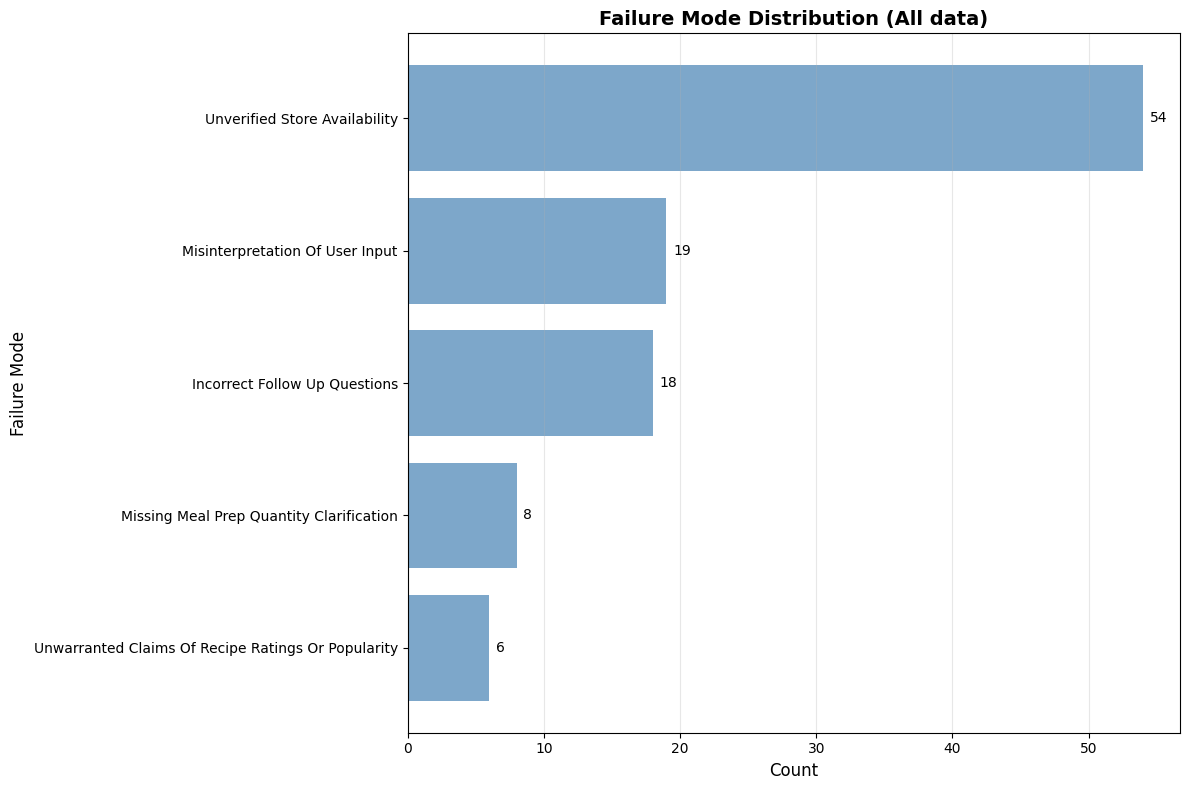


Failure Mode Analysis - Filtered (open_code_notes not empty):


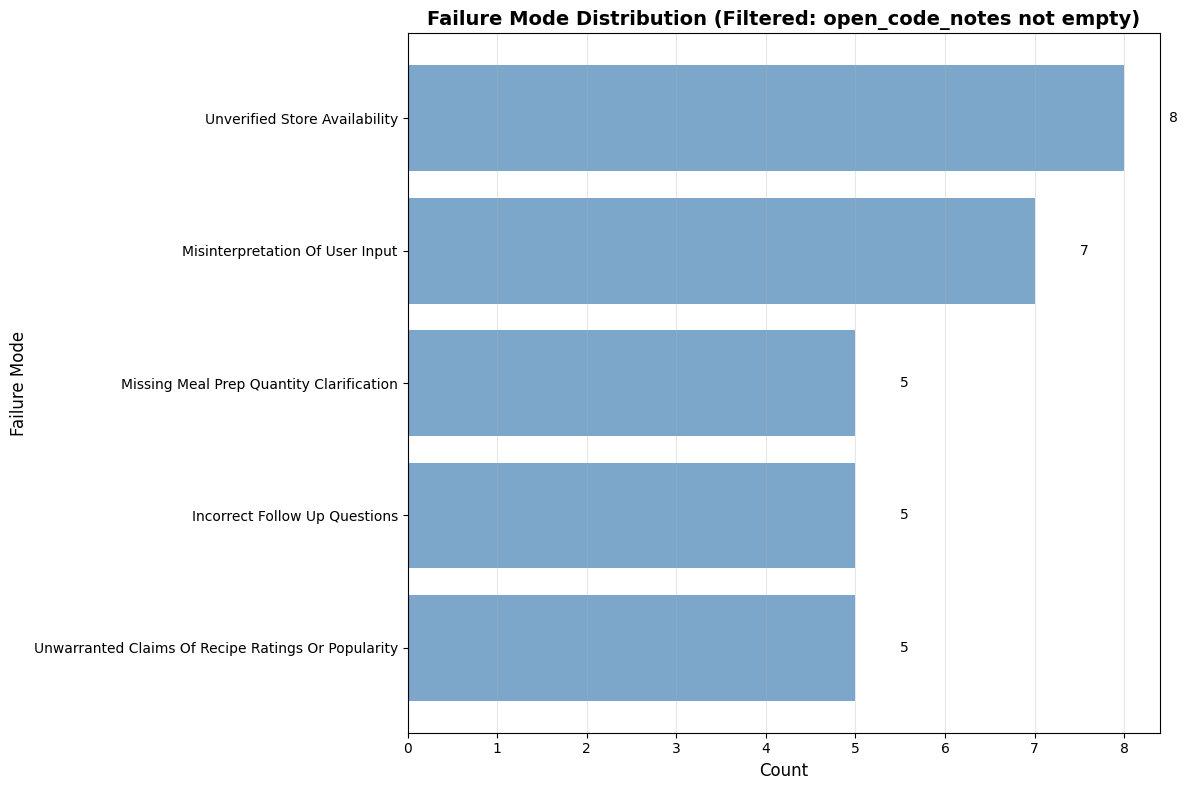


Summary Statistics:
Total records: 135
Records with open_code_notes: 21
Records without open_code_notes: 114


In [68]:
# Load the data
df = pd.DataFrame(combined_data)

# Get all failure mode columns (excluding metadata columns)
failure_mode_cols = [
    col
    for col in df.columns
    if col
    in [
        "unverified_store_availability",
        "missing_meal_prep_quantity_clarification",
        "incorrect_follow_up_questions",
        "unwarranted_claims_of_recipe_ratings_or_popularity",
        "misinterpretation_of_user_input",
    ]
]


def plot_failure_modes(filter_open_notes=False):
    # Filter data if requested
    if filter_open_notes:
        filtered_df = df[df["open_code_notes"] != ""]
        title_suffix = " (Filtered: open_code_notes not empty)"
    else:
        filtered_df = df
        title_suffix = " (All data)"

    # Count occurrences of each failure mode
    failure_counts = {}
    for col in failure_mode_cols:
        count = filtered_df[col].sum()
        failure_counts[col] = count

    # Sort by count (descending)
    sorted_counts = dict(sorted(failure_counts.items(), key=lambda x: x[1], reverse=True))

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Format labels for better readability
    labels = [label.replace("_", " ").title() for label in sorted_counts.keys()]
    values = list(sorted_counts.values())

    # Create horizontal bar chart
    bars = plt.barh(range(len(labels)), values, color="steelblue", alpha=0.7)

    # Customize the plot
    plt.yticks(range(len(labels)), labels)
    plt.xlabel("Count", fontsize=12)
    plt.ylabel("Failure Mode", fontsize=12)
    plt.title(f"Failure Mode Distribution{title_suffix}", fontsize=14, fontweight="bold")

    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, values)):
        plt.text(value + 0.5, i, str(value), va="center", fontsize=10)

    # Add grid for better readability
    plt.grid(axis="x", alpha=0.3)

    # Adjust layout
    plt.tight_layout()
    plt.gca().invert_yaxis()  # Highest values at top

    return plt.gcf()


# Plot all data
print("Failure Mode Analysis - All Data:")
fig1 = plot_failure_modes(filter_open_notes=False)
plt.show()

# Plot filtered data (only records with open_code_notes)
print("\nFailure Mode Analysis - Filtered (open_code_notes not empty):")
fig2 = plot_failure_modes(filter_open_notes=True)
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Total records: {len(df)}")
print(f"Records with open_code_notes: {len(df[df['open_code_notes'] != ''])}")
print(f"Records without open_code_notes: {len(df[df['open_code_notes'] == ''])}")


## Fin
